In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from numba import jit, objmode, njit, prange
import pandas as pd

In [2]:
THIS = 'dissipation-theory--Study-56--'
figs = {}

# Newton-Cotes integration

We wish to compute a numerical approximation to the following unitless integral:

\begin{equation}
{\cal I}_{\ell}(x) = \int_{0}^{\infty} dy \, y^{\ell} e^{-y} J_{0}(y \, x).
\end{equation}

Define a function to rapidly evaluate the integrand.

In [124]:
@jit(nopython=True)
def integrand(ell, y, x):
    return y**ell * np.exp(-y) * scipy.special.j0(y * x)

Plot the ${\cal I}_{2}$ integrand for $x = 0, 2, 4$ and $y$ in the range [0, 15.].  Do this for various numbers of data points.

In [4]:
def plotme(N, ymax):

    with plt.style.context('seaborn-v0_8'):

        fig, axs = plt.subplots(1, 3, figsize=(3.50 * 3, 3.5), sharey=True)

        y = np.linspace(0, ymax, N)
        for index in [0, 1, 2]:
            axs[index].plot(y, np.array([integrand(index, y_, 0.) for y_ in y]), '-', label='x = 0')
            axs[index].plot(y, np.array([integrand(index, y_, 2.) for y_ in y]), '-', label='x = 3')
            axs[index].plot(y, np.array([integrand(index, y_, 4.) for y_ in y]), '-', label='x = 5')
            axs[index].set_ylabel('${\cal I}_{' + '{:d}'.format(index) + '}$ integrand')
            axs[index].set_xlabel('$y$')
            axs[index].legend(frameon=False)
        
        return fig

We estimated that $N = 35$ and $y_{\mathrm{max}} = 15$ were good parameters for Newton-Cotes integration. 

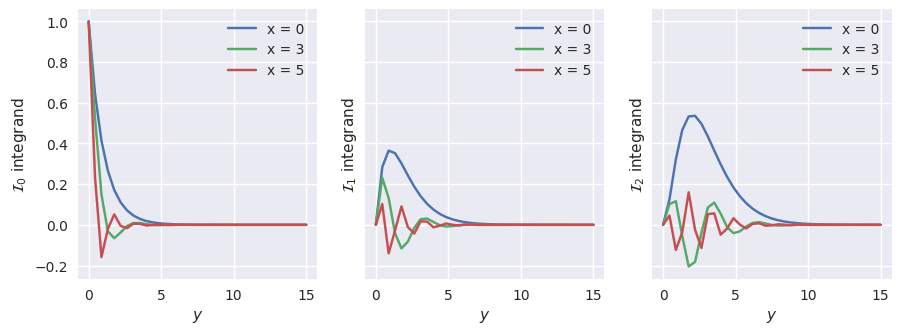

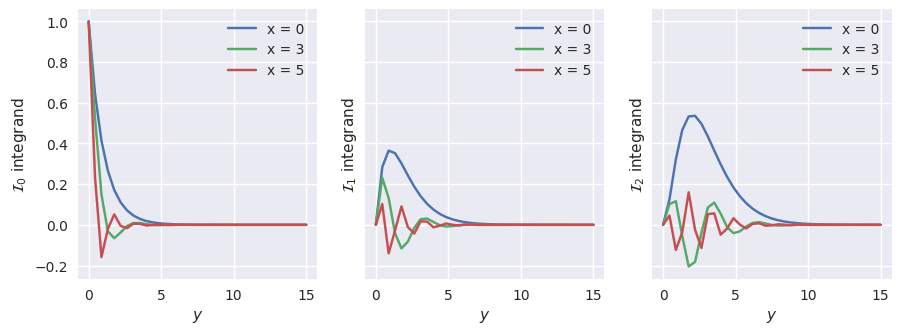

In [5]:
plotme(N=35, ymax=15.)

However, the function looks not well samples at at large $x$. \
Let us plot the integrand with a finer $y$ axis sampling.

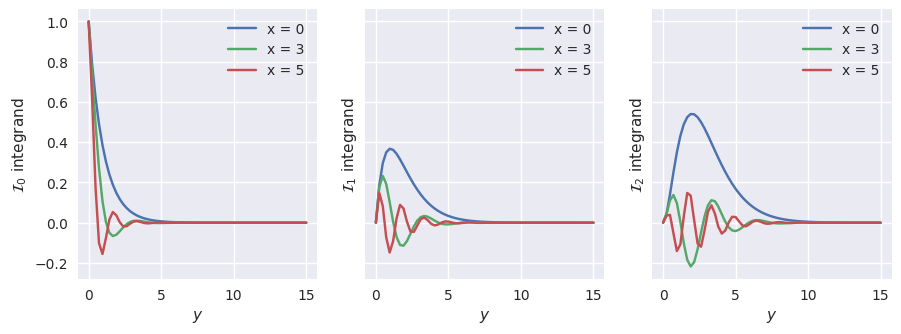

In [6]:
figs['01'] = plotme(N=64, ymax=15.)
figs['01']

A function to perform Newton-Cotes integration.

In [7]:
@jit(nopython=True)
def Imockup(ell, x, an, ymax):
    
    N = len(an) - 1
    y_vector = np.linspace(0., ymax, N+1)
    dy = ymax / N
    
    integral = np.zeros_like(y_vector)
    for m, y in enumerate(y_vector):
        integral[m] = integrand(ell, y, x)
    
    return dy * (an * integral).sum()

Compute the integral ${\cal I}_2(x=2)$ numerically using Newton-Cotes integration with $N = 35$ and $y_{\mathrm{max}} = 15$.

In [8]:
an, _ = scipy.integrate.newton_cotes(35, 1)
Imockup(2, 2., an, 15.)

-0.035394736061150935

The integral has the following analytical solutions:
\begin{equation}
{\cal I}_{0}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{1/2}}, \text{ }
{\cal I}_{1}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{3/2}}, \text{ and }
{\cal I}_{2}^{\mathrm{calc}}(x) = \frac{2 - x^2}{(1 + x^2)^{5/2}}
\end{equation}
Code these solutions into the following function.

In [9]:
@jit(nopython=True)
def Iexact(ell, x):
    if ell == 0:
        return np.power(1 + x**2, -1/2)
    elif ell == 1:
        return np.power(1 + x**2, -3/2)
    elif ell == 2:
        return (2 - x**2) * np.power(1 + x**2, -5/2)

Compute the exact integral ${\cal I}_2(x=2)$.

In [10]:
Iexact(2, 2.)

-0.03577708763999664

A utility function to compare two numbers $a$ and $b$. \
Print out the normalized difference as a *percentage*.

In [11]:
def compare(a, b, norm):
    pct1 = 100*(a-b)/norm
    pct2 = 100*(a-b)/a
    print("a = {:+0.6f}  b = {:+0.6f}  epsilon b = {:+0.4f}% vs {:0.1f} and {:+0.4f}% vs a".format(a, b, pct1, norm, pct2))

There are two ways to evaluate the Newton-Cotes integration.  

The error relative to ${\cal I}_{2}(0) = 2$, the value of the integral at $x = 0$, is about -0.005%. \
The relative error is considerably worse, about +0.26%.

In [12]:
an, _ = scipy.integrate.newton_cotes(30, 1)
compare(
    Iexact(2, 2.),
    Imockup(2, 2., an, 15.),
    Iexact(2, 0.))

a = -0.035777  b = -0.035686  epsilon b = -0.0046% vs 2.0 and +0.2559% vs a


In [13]:
an, _ = scipy.integrate.newton_cotes(30, 1)
compare(
    Iexact(0, 0.),
    Imockup(0, 0., an, 15.),
    Iexact(0, 0.))

a = +1.000000  b = +0.999999  epsilon b = +0.0001% vs 1.0 and +0.0001% vs a


# Fourier integration

Extend the $y$ axis maximum from 15 to 25.  \
Do this tp guarantee that the "left" part of the integrand has decayed to zero at the end of the range.

In [14]:
N = 32
y = np.linspace(0., 25., N, endpoint=True)

Our Fourier sums run from $n = 0$ to $n = N-1$. Check that $(N-1) * \Delta y = 25.$

In [15]:
dy = y[1] - y[0]

In [16]:
(N - 1) * dy

25.0

Split the integrand into two parts.  Here the "left" part of the integrand is
\begin{equation}
y^\ell e^{-y/2}
\end{equation}
with $r_{\mathrm{p}}(y, \omega) = 1$ for metal and the "right" part of the integrand is
\begin{equation}
e^{-y/2} J_0(y \, x).
\end{equation}

In [17]:
@jit(nopython=True)
def integrandL(ell, y, x):
    return y**ell * np.exp(-y/2)

In [18]:
@jit(nopython=True)
def integrandR(ell, y, x):
    return np.exp(-y/2) * scipy.special.j0(y * x)

Generate an array of integrands.

In [19]:
I2L = np.array([integrandL(2, y_, 2.) for y_ in y])
I2R = np.array([integrandR(2, y_, 2.) for y_ in y])

In [20]:
def plotme2(y_array, I2L, I2R):

    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.50, 2.5))

        y = np.linspace(0, 15., N)
        plt.plot(y_array, np.array([integrandL(2, y_, 0.) for y_ in y_array]), '.-', label='left')
        plt.plot(y_array, np.array([integrandR(2, y_, 0.) for y_ in y_array]), '.-', label='right, x=0')
        plt.plot(y_array, np.array([integrandR(2, y_, 2.) for y_ in y_array]), '.-', label='right, x=2')
        plt.ylabel('${\cal I}_{2}$ integrand part')
        plt.xlabel('$y$')
        plt.legend(frameon=False)

        return fig

In [21]:
_ = plotme2(y, I2L, I2R)

Now compute Fourier transforms.

In [22]:
I2Lfft = np.fft.fft(I2L)
I2Rfft = np.fft.fft(I2R)

In [23]:
result = np.real((dy / N) * (I2Lfft  * np.conj(I2Rfft)).sum())
result

-0.040273058112744266

Do the same two comparisons.

In [24]:
compare(
    Iexact(2, 2.),
    result,
    Iexact(2, 0.))

a = -0.035777  b = -0.040273  epsilon b = +0.2248% vs 2.0 and -12.5666% vs a


For comparison, Newton-Cotes achieved about 0.005% vs 2.0 (45x better) and 0.26% relative (48x better).

Mock up a function to perform the integration by Fourier methods.  \
The package `numba` only supports the three-argument version of `np.linspace`, so we will effectively have `endpoint=False`. \
This change should not cause too big an error. \
The `np.fft.fft` function is not supported by `numba`, but you can incorporate it into a `numba` compiled function using `objmode` ([manual](https://numba.readthedocs.io/en/stable/user/withobjmode.html), [example](https://stackoverflow.com/questions/62213330/how-to-make-discrete-fourier-transform-fft-in-numba-njit)). 

In [25]:
@jit(nopython=True)
def IFTmockup(ell, x, N, ymax):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)

    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

Show that we get the same answer as before.  \
The `IFTmockup` function return a complex number.  Take the real part for comparison purposes.

Look at the performance at $x = 0$, with $N = 32$ and $y_{\mathrm{max}} = 25$.

In [26]:
compare(
    Iexact(2, 0.),
    IFTmockup(2, 0., 32, 25.).real,
    Iexact(2, 0.))

a = +2.000000  b = +1.996651  epsilon b = +0.1674% vs 2.0 and +0.1674% vs a


Now look at the performance at $x = 2$.

In [27]:
compare(
    Iexact(2, 2.),
    IFTmockup(2, 2., 32, 25.).real,
    Iexact(2, 0.))

a = -0.035777  b = -0.040273  epsilon b = +0.2248% vs 2.0 and -12.5666% vs a


Again, for comparison, Newton-Cotes achieved about 0.005% and 0.26% relative (about 50x better).

It's not hard to see why the FT integration method might be performing much worse. \
With $y_{\mathrm{max}} = 25$ and $N = 32$, we are not sampling the $x = 2$ oscillations in $J_0(y x)$ very well.

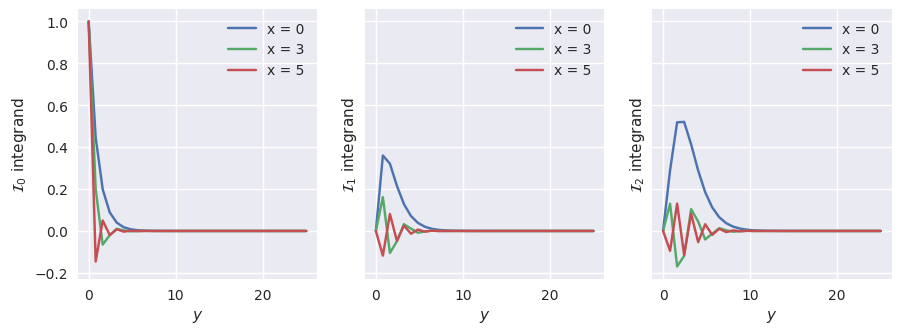

In [28]:
figs['02'] = plotme(N=32, ymax=25.)
figs['02'] 

When we increase $N$ we capture the oscillations much better.

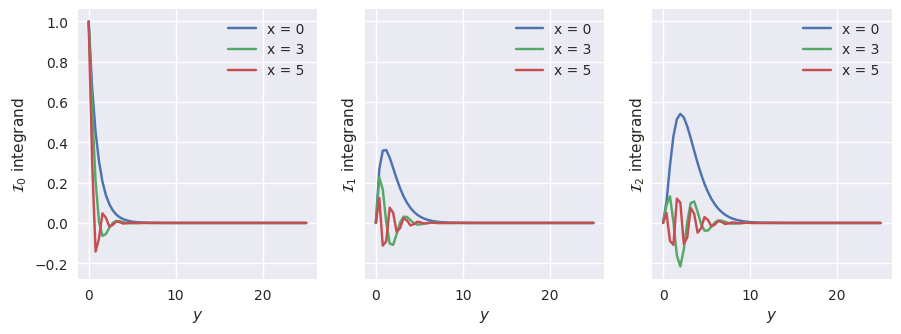

In [29]:
figs['03'] = plotme(N=64, ymax=25.)
figs['03'] 

With $N = 64$ instead of $32$ the error is considerably better, both at $x = 0$ and $x = 2$.  \
It's even better if I decrease $y_{\mathrm{max}}$ a little, to $20$.

The FT-method result at $x = 0$:

In [30]:
compare(
    Iexact(2, 0.),
    IFTmockup(2, 0., 64, 20.).real,
    Iexact(2, 0.))

a = +2.000000  b = +1.999915  epsilon b = +0.0042% vs 2.0 and +0.0042% vs a


The FT-method result at $x = 2$:

In [31]:
compare(
    Iexact(2, 2.),
    IFTmockup(2, 2., 64, 20.).real,
    Iexact(2, 0.))

a = -0.035777  b = -0.035865  epsilon b = +0.0044% vs 2.0 and -0.2460% vs a


Again, for comparison, Newton-Cotes achieved about 0.005% and 0.26% relative. \
We can see that with $N = 64$ and $y_{\mathrm{max}} = 20$ the FT approach can get comparable performance to Newton-Cotes with $N = 30$. \


I suspect that the FT approach will work *much* better at large $x$. \
Let's test that idea.

Newton-Coates at $x = 3$ is a disaster

In [32]:
an, _ = scipy.integrate.newton_cotes(30, 1)
compare(
    Iexact(2, 3.),
    Imockup(2, 3., an, 15.),
    Iexact(2, 0.))

a = -0.022136  b = -0.676288  epsilon b = +32.7076% vs 2.0 and -2955.1583% vs a


wheareas at $x = 3$ the FT approach is still very good.

In [33]:
compare(
    Iexact(2, 3.),
    IFTmockup(2, 3., 64, 20.).real,
    Iexact(2, 0.))

a = -0.022136  b = -0.022229  epsilon b = +0.0047% vs 2.0 and -0.4224% vs a


Newton-Coates at $x = 5$ gives total nonsense

In [34]:
an, _ = scipy.integrate.newton_cotes(30, 1)
compare(
    Iexact(2, 5.),
    Imockup(2, 5., an, 15.),
    Iexact(2, 0.))

a = -0.006673  b = +2744.954340  epsilon b = -137248.0506% vs 2.0 and +41137861.7551% vs a


while at $x = 5$ the FT approach still has very good accuracy.

In [35]:
compare(
    Iexact(2, 5.),
    IFTmockup(2, 5., 64, 20.).real,
    Iexact(2, 0.))

a = -0.006673  b = -0.006786  epsilon b = +0.0057% vs 2.0 and -1.7019% vs a


**For $x \geq 2$, the FT approach maintains good accuracy, whereas Newton-Cotes breaks down.**

# Speed test

Newton-Cotes ($N = 30$, $y_{\mathrm{max}} = 15$) takes 3.0 microseconds.

In [36]:
an, _ = scipy.integrate.newton_cotes(30, 1)

In [37]:
%%timeit
Imockup(2, 2., an, 15.)

4.17 μs ± 654 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The FT method ($N = 64$, $y_{\mathrm{max}} = 20$) takes 21 microseconds.

In [38]:
%%timeit
IFTmockup(2, 2., 64, 20.).real

39 μs ± 11.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**The FT approach is about $7 \times$ slower than Newton-Cotes, but has dramatically better accuracy for $x \geq 2$.**

Can I speed up the FT approach a little?
In the case of a semiconductor, the "left" part of the integrand can remain
\begin{equation}
y^\ell e^{-y/2} \, 
\end{equation}
while the "right" part of the integrand should become
\begin{equation}
e^{-y/2} J_0(y \, \rho \big/ z^{\mathrm{ref}}_{k,j}) r_{p}(y \big/ z^{\mathrm{ref}}_{k,j}, \omega)
\end{equation}
with $z^{\mathrm{ref}}_{k,j} = r_{k}^{z} + s_{j}^{z}$ a reference distance and $r_p$ the Fresnel reflection coefficient for $p$ polarization.

Let us *precompute* the FFT of the left part of the integrand.

In [39]:
def IFTmockup2pre(ell, N, ymax):
    
    y_vector = np.linspace(0., ymax, N)
    IL = np.zeros_like(y_vector)    
    
    for m, y in enumerate(y_vector):
        IL[m] = integrandL(ell, y, 0.) # doesn't depend on x, so set to 0
        
    ILfft = np.fft.fft(IL)
    
    return ILfft

Now we just pass the precomputed FT of the left hand part of the integrand to the "real" workup routine.

In [40]:
@jit(nopython=True)
def IFTmockup2(ell, x, N, ymax, ILfft):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]
    
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector):
        IR[m] = integrandR(ell, y, x)

    with objmode(IRfft='complex128[:]'):
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

Do the precomputation.

In [41]:
ILfft = IFTmockup2pre(2, 64, 20.)

Time the revised computation.

In [42]:
%%timeit
IFTmockup2(2, 2., 64, 20., ILfft).real

The slowest run took 5.38 times longer than the fastest. This could mean that an intermediate result is being cached.
23 μs ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


I am surprised to find that the trimmed-down algorithm is no faster, even though we removed a matrix-setup calculation and eliminated one an FFTs.

Compile it better, using parallel processing.

In [43]:
@njit(parallel=True)
def IFTmockup3(ell, x, N, ymax, ILfft):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]
    
    IR = np.zeros_like(y_vector)

    for m in prange(len(y_vector)):
        IR[m] = integrandR(ell, y_vector[m], x)

    with objmode(IRfft='complex128[:]'):
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

Now run it.

In [44]:
%%timeit
IFTmockup3(2, 2., 64, 20., ILfft).real

The slowest run took 5.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1.24 ms ± 644 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Argh, it runs *slower*.  By a factor of about 15.  What the heck!

# Test the accuracy of the $\ell = 0$ and $\ell = 1$ components

## Test the two methods at $x = 0$

In [45]:
x_value = 0.0

Newton-Cotes has worse accuracy at higher $\ell$.

In [46]:
for ell in [0, 1, 2]:
    
    print("ell = {:d}:  ".format(ell), end='')
    an, _ = scipy.integrate.newton_cotes(30, 1)
    compare(
        Iexact(ell, x_value),
        Imockup(ell, x_value, an, 15.),
        Iexact(ell, 0.))

ell = 0:  a = +1.000000  b = +0.999999  epsilon b = +0.0001% vs 1.0 and +0.0001% vs a
ell = 1:  a = +1.000000  b = +0.999993  epsilon b = +0.0007% vs 1.0 and +0.0007% vs a
ell = 2:  a = +2.000000  b = +1.999906  epsilon b = +0.0047% vs 2.0 and +0.0047% vs a


In contrast, the FT integrator has better accuracy at higher $\ell$.  This is a surprise!

In [47]:
N = 64
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +1.000000  b = +1.167115  epsilon b = -16.7115% vs 1.0 and -16.7115% vs a
ell = 1:  a = +1.000000  b = +0.991644  epsilon b = +0.8356% vs 1.0 and +0.8356% vs a
ell = 2:  a = +2.000000  b = +1.999915  epsilon b = +0.0042% vs 2.0 and +0.0042% vs a


But why is the FT integrator accuracy so bad for the $\ell = 0$ and $\ell = 1$ integrations?

**Is the assymmetry in the $\ell = 0$ integrand causing a problem with the FT method**? \
That would explain the error in the $\ell = 0$ integral but probably not the $\ell = 1$ integral.
 
Increasing $N$ four-fold from 64 to 256 decreases the ${\cal I}_{0}(0)$ error from 16% to 4%, a four-fold decrease. 

In [48]:
N = 256
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +1.000000  b = +1.039728  epsilon b = -3.9728% vs 1.0 and -3.9728% vs a
ell = 1:  a = +1.000000  b = +0.999487  epsilon b = +0.0513% vs 1.0 and +0.0513% vs a
ell = 2:  a = +2.000000  b = +1.999999  epsilon b = +0.0001% vs 2.0 and +0.0001% vs a


Suprisingly, the resulting increase in execution time is sublinear in $N$.  Good news.

In [49]:
%%timeit
IFTmockup(ell, x_value, 64, 20.).real

25.9 μs ± 5.25 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
%%timeit
IFTmockup(ell, x_value, 256, 20.).real

30.8 μs ± 2.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Test the two methods at $x = 5$

In [51]:
x_value = 5.0

As we know, Newton-Cotes is a disaster.  This is expected.

In [52]:
for ell in [0, 1, 2]:
    
    print("ell = {:d}:  ".format(ell), end='')
    an, _ = scipy.integrate.newton_cotes(30, 1)
    compare(
        Iexact(ell, x_value),
        Imockup(ell, x_value, an, 15.),
        Iexact(ell, 0.))

ell = 0:  a = +0.196116  b = -44.576280  epsilon b = +4477.2396% vs 1.0 and +22829.5320% vs a
ell = 1:  a = +0.007543  b = +127.856275  epsilon b = -12784.8732% vs 1.0 and -1694948.2647% vs a
ell = 2:  a = -0.006673  b = +2744.954340  epsilon b = -137248.0506% vs 2.0 and +41137861.7551% vs a


The FT method is *very bad* at $\ell = 0, 1$ and *fairly good* at $\ell = 2$.

In [53]:
N = 64
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +0.196116  b = +0.363797  epsilon b = -16.7681% vs 1.0 and -85.5010% vs a
ell = 1:  a = +0.007543  b = -0.001370  epsilon b = +0.8913% vs 1.0 and +118.1655% vs a
ell = 2:  a = -0.006673  b = -0.006786  epsilon b = +0.0057% vs 2.0 and -1.7019% vs a


This behavior in somewhat unexpected.  The FT method gets better is we increase $N$ from $64$ to $256$.

In [54]:
N = 256
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +0.196116  b = +0.235846  epsilon b = -3.9730% vs 1.0 and -20.2585% vs a
ell = 1:  a = +0.007543  b = +0.007028  epsilon b = +0.0514% vs 1.0 and +6.8202% vs a
ell = 2:  a = -0.006673  b = -0.006673  epsilon b = +0.0000% vs 2.0 and -0.0050% vs a


Even with $N = 256$, the behavior at $\ell = 0, 1$ is still too bad to be useable. \
Plot the integrand.

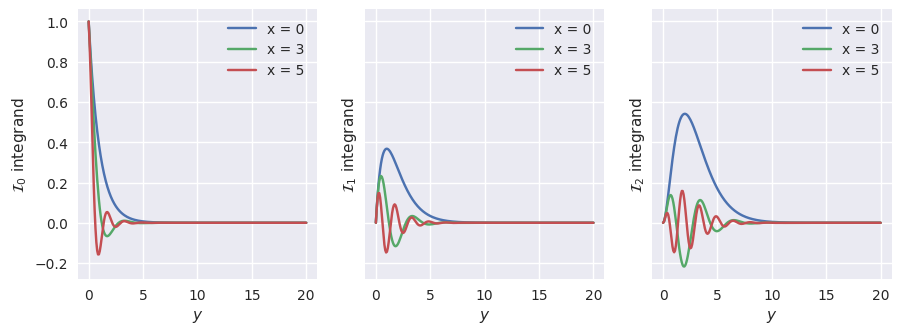

In [55]:
figs['04'] = plotme(N=256, ymax=20.)
figs['04']

# Revise the FT algorithm

In [56]:
@jit(nopython=True)
def IFTmockup(ell, x, N, ymax):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)

    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum(), y_vector, IL, IR

In [57]:
ans, y, IL, IR = IFTmockup(0, x_value, 256, 20.)

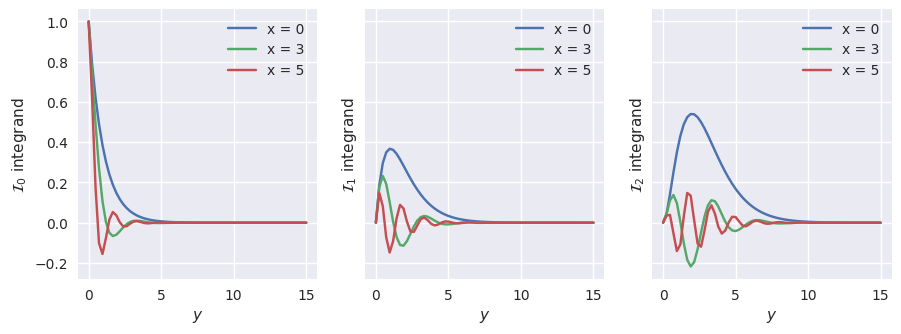

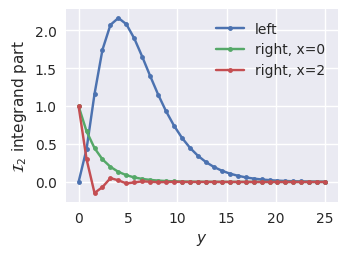

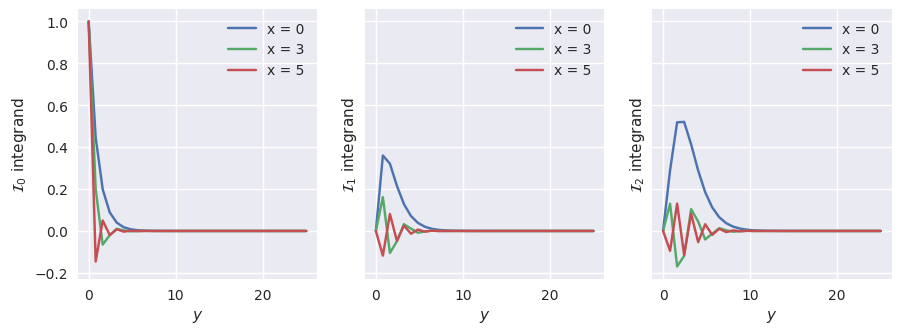

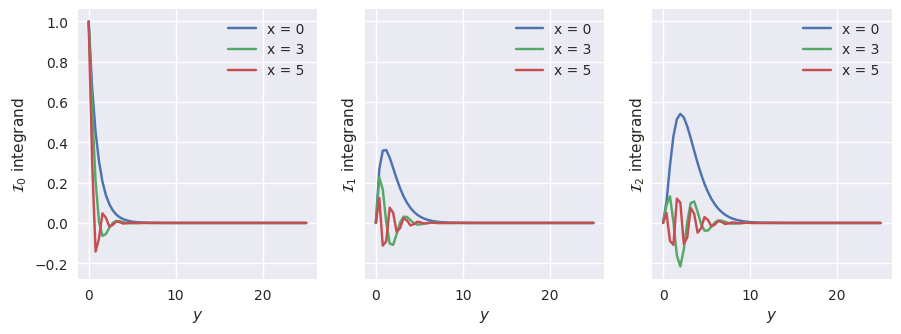

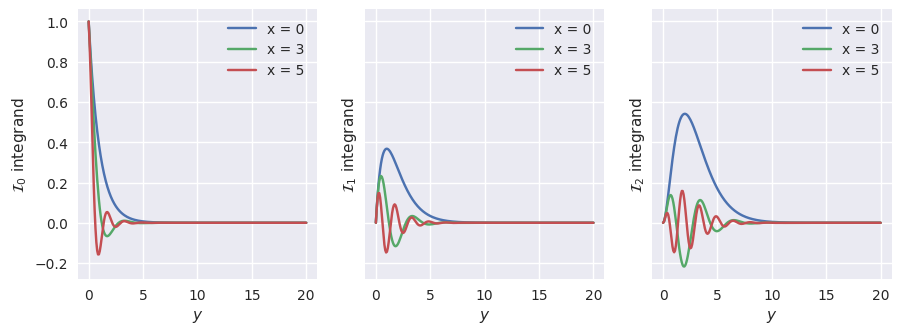

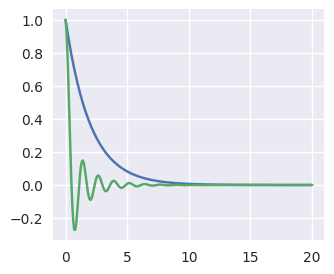

In [58]:
with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.5, 3.0))
    plt.plot(y, IL)
    plt.plot(y, IR)
    
plt.show()

Play with making a reversed $y$ axis array to traverse in the loop.

In [59]:
y_test = np.linspace(0., 20., 2 * 16)
y_test

array([ 0.        ,  0.64516129,  1.29032258,  1.93548387,  2.58064516,
        3.22580645,  3.87096774,  4.51612903,  5.16129032,  5.80645161,
        6.4516129 ,  7.09677419,  7.74193548,  8.38709677,  9.03225806,
        9.67741935, 10.32258065, 10.96774194, 11.61290323, 12.25806452,
       12.90322581, 13.5483871 , 14.19354839, 14.83870968, 15.48387097,
       16.12903226, 16.77419355, 17.41935484, 18.06451613, 18.70967742,
       19.35483871, 20.        ])

This will get the first half:

In [60]:
(y_test[0:16].shape, y_test[0:16])

((16,),
 array([0.        , 0.64516129, 1.29032258, 1.93548387, 2.58064516,
        3.22580645, 3.87096774, 4.51612903, 5.16129032, 5.80645161,
        6.4516129 , 7.09677419, 7.74193548, 8.38709677, 9.03225806,
        9.67741935]))

This, after some trial and error, will get the second half:

In [61]:
(y_test[0:16][::-1].shape,y_test[0:16][::-1])

((16,),
 array([9.67741935, 9.03225806, 8.38709677, 7.74193548, 7.09677419,
        6.4516129 , 5.80645161, 5.16129032, 4.51612903, 3.87096774,
        3.22580645, 2.58064516, 1.93548387, 1.29032258, 0.64516129,
        0.        ]))

In [62]:
@jit(nopython=True)
def IFTmockup4(ell, x, N, ymax):

    y_vector = np.linspace(0., 2 * ymax, 2 * N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector[0:N]):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)
    for m, y in enumerate(y_vector[0:N][::-1]):
        IL[m+N] = integrandL(ell, y, x)
        IR[m+N] = integrandR(ell, y, x)
        
    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum(), y_vector, IL, IR

In [63]:
ans, y, IL, IR = IFTmockup4(0, x_value, 16, 20.)

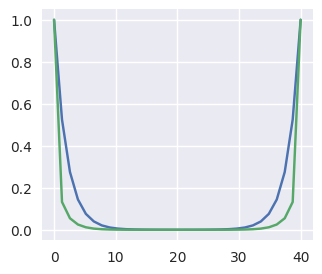

In [64]:
with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.5, 3.0))
    plt.plot(y, IL)
    plt.plot(y, IR)
    
plt.show()

Make a new version that just returns the answer.

In [65]:
@jit(nopython=True)
def IFTmockup5(ell, x, N, ymax):

    y_vector = np.linspace(0., 2 * ymax, 2 * N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector[0:N]):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)
    for m, y in enumerate(y_vector[0:N][::-1]):
        IL[m+N] = integrandL(ell, y, x)
        IR[m+N] = integrandR(ell, y, x)
        
    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

Compare the old method to the new method.

In [66]:
N = 64
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup5(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +0.196116  b = +1.449592  epsilon b = -125.3476% vs 1.0 and -639.1499% vs a
ell = 1:  a = +0.007543  b = -0.004888  epsilon b = +1.2431% vs 1.0 and +164.8030% vs a
ell = 2:  a = -0.006673  b = -0.027128  epsilon b = +1.0228% vs 2.0 and -306.5655% vs a


Uh-oh, we have made the answers *worse*.  Here is the factor by which each integrand is off:

In [67]:
(1.449592/0.196116, -0.004888/+0.007543, -0.006673/-0.027128)

(7.391502988027494, -0.6480180299615538, 0.2459820112061339)

The integrals are not off by a constant factor, although the factor is tending to 1/4 for $\ell = 2$. \
Arrgh!  What's going on?

There is another way to make the integrand cyclic: have it start at zero, increase, and decrease to zero. \
To achieve this, just swap the arrays that are enumerated.

In [68]:
@jit(nopython=True)
def IFTmockup6(ell, x, N, ymax):

    y_vector = np.linspace(0., 2 * ymax, 2 * N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector[0:N][::-1]): 
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)
    for m, y in enumerate(y_vector[0:N]):
        IL[m+N] = integrandL(ell, y, x)
        IR[m+N] = integrandR(ell, y, x)
        
    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum(), y_vector, IL, IR

Verify that the `IL` and `iIR` arrays are being returned as expected.

In [69]:
ans, y, IL, IR = IFTmockup6(0, x_value, 16, 20.)

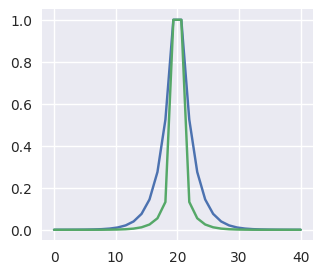

In [70]:
with plt.style.context('seaborn-v0_8'):

    fig = plt.figure(figsize=(3.5, 3.0))
    plt.plot(y, IL)
    plt.plot(y, IR)
    
plt.show()

Ok, the array looks like I expected.  Now revise the algorithm to return just the answer.

In [71]:
@jit(nopython=True)
def IFTmockup7(ell, x, N, ymax):

    y_vector = np.linspace(0., 2 * ymax, 2 * N)
    dy = y_vector[1] - y_vector[0]
        
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector[0:N][::-1]): 
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)
    for m, y in enumerate(y_vector[0:N]):
        IL[m+N] = integrandL(ell, y, x)
        IR[m+N] = integrandR(ell, y, x)
        
    with objmode(ILfft='complex128[:]',IRfft='complex128[:]'):
        ILfft = np.fft.fft(IL)
        IRfft = np.fft.fft(IR)

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

The answers have not changed!  The integrals are still horribly off.

In [72]:
N = 64
for ell in [0, 1, 2]:

    print("ell = {:d}:  ".format(ell), end='')
    compare(
        Iexact(ell, x_value),
        IFTmockup7(ell, x_value, N, 20.).real,
        Iexact(ell, 0.))

ell = 0:  a = +0.196116  b = +1.449592  epsilon b = -125.3476% vs 1.0 and -639.1499% vs a
ell = 1:  a = +0.007543  b = -0.004888  epsilon b = +1.2431% vs 1.0 and +164.8030% vs a
ell = 2:  a = -0.006673  b = -0.027128  epsilon b = +1.0228% vs 2.0 and -306.5655% vs a


OK, time to roll up my sleeves and look at the Fourier transforms. \
Back up to the original algorithm and return the FT-ed integrands for plotting.

In [73]:
@jit(nopython=True)
def IFTmockup8(ell, x, N, ymax, verbose=True):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]


    freq = np.zeros_like(y_vector)
    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)

    # IL[0] = 0.5 * IL[0]
    # IR[0] = 0.5 * IR[0]
    
    with objmode(ILfft='complex128[:]', IRfft='complex128[:]',freq='float64[:]'):
        
        freq = \
            np.fft.fftshift(
                np.fft.fftfreq(y_vector.size, dy))
        
        ILfft = dy * \
            np.fft.fftshift(
                np.fft.fft(IL))

        IRfft = dy * \
            np.fft.fftshift(
                np.fft.fft(IR))

    return (1 / (N * dy)) * (ILfft  * np.conj(IRfft)).sum(), y_vector, IL, IR, freq, ILfft, IRfft

A plotter function.

In [74]:
def plotme8(y, IL, IR, freq, ILfft, IRfft):
    
    with plt.style.context('seaborn-v0_8'):
    
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(2.5 * 4, 3.0))
        
        ax1.plot(y, IL, label='$f_n$')
        ax1.plot(y, IR, label='$g_n$')
        ax1.legend(frameon=False)
        ax1.set_xlabel('$y_n$')
        
        ax2.plot(freq, ILfft.real, label='Re[$F_k$]')
        ax2.plot(freq, ILfft.imag, label='Im[$F_k$]')
        ax2.legend(frameon=False,fontsize=9)
        ax2.set_xlabel('$Y_k$')
        
        ax3.plot(freq, IRfft.real, label='Re[$G_k$]')
        ax3.plot(freq, IRfft.imag, label='Im[$G_k$]')
        ax3.legend(frameon=False,fontsize=9)
        ax3.set_xlabel('$Y_k$')

        result = (ILfft  * np.conj(IRfft))        
        ax4.plot(freq, result.real, label='Re[$F_k G_k^{*}$]')
        ax4.plot(freq, result.imag, label='Im[$F_k G_k^{*}$]')
        ax4.legend(frameon=False,fontsize=9)
        ax4.set_xlabel('$Y_k$')

        plt.tight_layout()
        
    return fig
    

Let's look at the integrands and FTs for $\ell = 0$ and $x = 2$ (some oscillation).

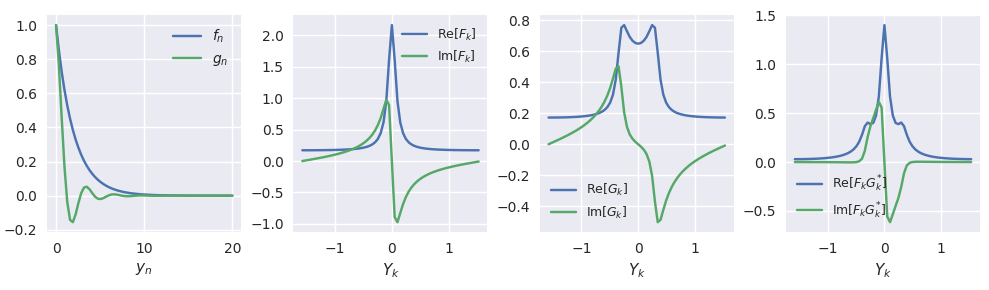

In [75]:
ans, y, IL, IR, freq, ILfft, IRfft = IFTmockup8(0, 2., 64, 20.)
figs['05'] = plotme8(y, IL, IR, freq, ILfft, IRfft)
figs['05']

The two integrands looks like expected. \
The FT of the two integrands are somewhat surprising. \
The imaginary parts decay very slowly and the real parts have a funny dc offset. \
(I verify [code not shown] that the dc offset is not due to the compilation introducting errors in the FFT.)

Let's look at the integrands and FTs for $\ell = 1$ and still $x = 2$.

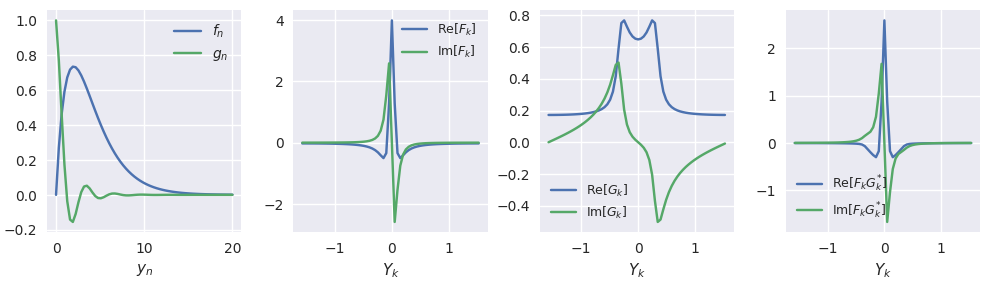

In [76]:
ans, y, IL, IR, freq, ILfft, IRfft = IFTmockup8(1, 2., 64, 20.)
figs['06'] = plotme8(y, IL, IR, freq, ILfft, IRfft)
figs['06']

The FT of the left integrand is narrower, as expected, because the integrand extends further in $y$. \
The FT of the right integrand looks the same.

Why the funny dc offsets in the Fourier transform? 

Make my own Fourier transforming function and plug in a simple exponential signal.

In [77]:
def myFT(x, y):

    dx = x[1] - x[0]
    
    freq = \
        np.fft.fftshift(
            np.fft.fftfreq(len(x), dx))
    
    y_fft = dx * \
        np.fft.fftshift(
            np.fft.fft(y))

    with plt.style.context('seaborn-v0_8'):
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.0 * 2, 3.0))
        
        ax1.plot(x, y)
        ax1.set_ylabel('$y_n$')
        ax1.set_xlabel('$x_n$')
        
        ax2.plot(freq, y_fft.real, label='Re[$Y_k$]')
        ax2.plot(freq, y_fft.imag, label='Im[$Y_k$]')
        ax2.legend(frameon=False,fontsize=9)
        ax2.set_xlabel('$X_k$')

        fig.tight_layout()
    
    return fig, freq, y_fft

There is a small dc offset in the Fourier transform

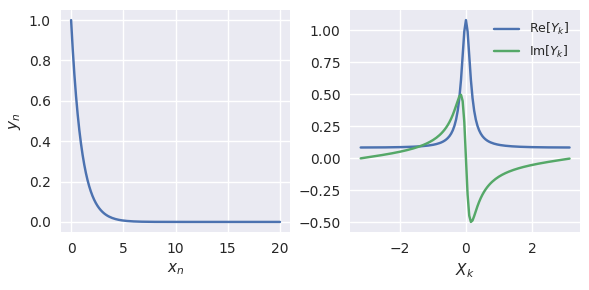

In [78]:
x = np.linspace(0, 20., 128)
y = np.exp(-x)
figs['07'], freq, y_fft = myFT(x, y)
figs['07']

In [79]:
y_fft[0]

(0.08492738804392155+0j)

Check that the time spacings and frequency spacings agree with expectations.  They do.

In [80]:
dx = x[1]-x[0]
(len(x), dx, 1/(2 * dx), freq[0], freq[-1], freq[1]-freq[0], 1/(len(x) * dx))

(128,
 0.15748031496062992,
 3.175,
 -3.175,
 3.1253906249999996,
 0.04960937500000018,
 0.049609375)

Compare the numerically computed FFT with what I calculate by hand.

In [81]:
def compareFT(X, Y, Ycalc):

    with plt.style.context('seaborn-v0_8'):
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.0 * 2, 3.0))
        
        ax1.plot(X, Y.real, '.', label='FFT.re')
        ax1.plot(X, Ycalc.real, '-', label='calc.re')
        ax1.legend(frameon=False)

        ax2.plot(X, Y.imag, '.', label='FFT.im')
        ax2.plot(X, Ycalc.imag, '-', label='calc.im')
        ax2.legend(frameon=False)
        
        fig.tight_layout()
        
        return fig

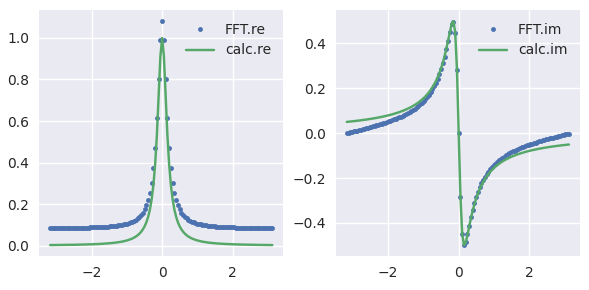

In [82]:
y_fft_calc = 1/(1 + 2 * np.pi * complex(0,1) * freq)
figs['08'] = compareFT(freq, y_fft, y_fft_calc)
figs['08']

The agreement is really not very good.

Calculate the FT of discrete data by hand.

In [83]:
def func(k0, dx, N):
    k = np.arange(N) - N/2  
    s = np.exp(-k0 * dx) * np.exp(- 2 * np.pi * complex(0,1) * k/N)
    return dx * (1 - s**N)/(1 - s)

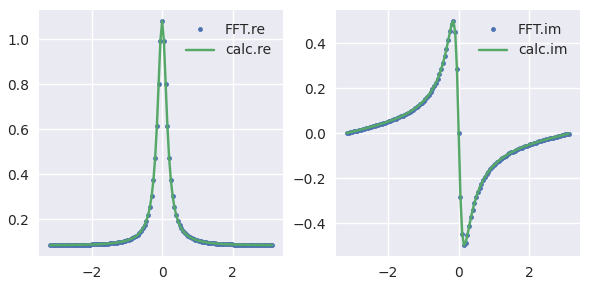

In [84]:
figs['09'] = compareFT(freq, y_fft, func(1, x[1]-x[0], 128))
figs['09']

Now the agreement is essentially quantitative!

Let the $x$-axis go out further.

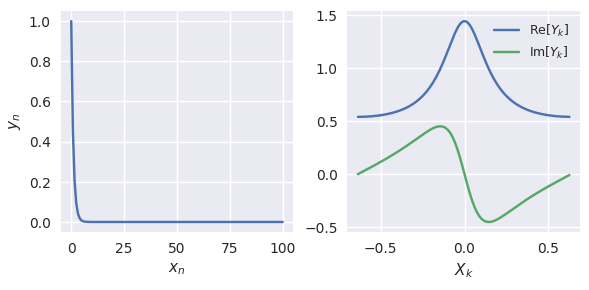

In [85]:
x = np.linspace(0, 100., 128)
y = np.exp(-x)
figs['10'], freq, y_fft = myFT(x, y)
figs['10']

The dc offset in the Fourier transform is now much worse

In [86]:
y_fft[0]

(0.5411599418740418+0j)

and the agreement with the continuous-time calculated FT is horrible.

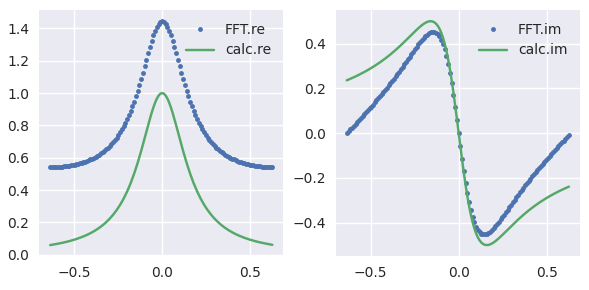

In [87]:
y_fft_calc = 1/(1 + 2 * np.pi * complex(0,1) * freq)
figs['11'] = compareFT(freq, y_fft, y_fft_calc)
figs['11']

Yet the agreement with the discrete-time calculated FT is again quantitative.

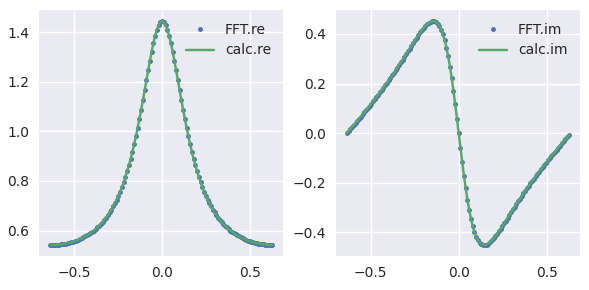

In [88]:
figs['12'] = compareFT(freq, y_fft, func(1, x[1]-x[0], 128))
figs['12']

Let's look at 

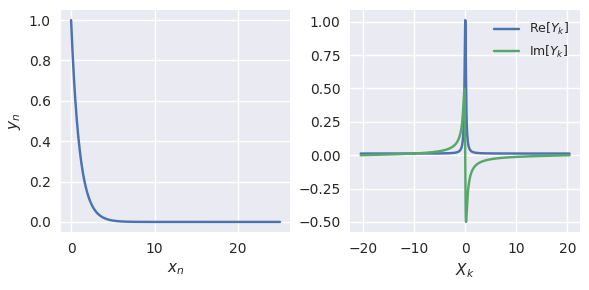

In [89]:
x = np.linspace(0, 25., 1024)
y = np.exp(-x)
figs['13'], freq, y_fft = myFT(x, y)
figs['13']

We still have a small dc offset problem in the FT data.

In [90]:
(4 * np.pi /1024, y_fft[0])

(0.01227184630308513, (0.012368259478798084+0j))

If we compare the continuous-time FT with the discrete-time FT, the two curves are in reasonable agreement (except for the dc offset problem).

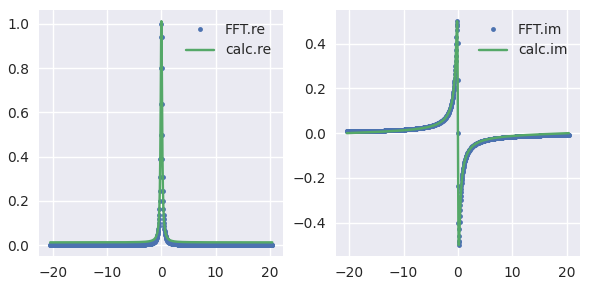

In [91]:
y_fft_calc1 = 1/(1 + 2 * np.pi * complex(0,1) * freq)
y_fft_calc2 =  func(1, x[1]-x[0], 1024)
figs['14'] = compareFT(freq, y_fft_calc1, y_fft_calc2)
figs['14']

**Unless $N$ is very large, the Fourier transform has a digitial artifact that is probably throwing off the integration.**

In [92]:
@jit(nopython=True)
def IFTmockup9(ell, x, N, ymax):

    y_vector = np.linspace(0., ymax, N)
    dy = y_vector[1] - y_vector[0]

    IL = np.zeros_like(y_vector)
    IR = np.zeros_like(y_vector)
    
    for m, y in enumerate(y_vector):
        IL[m] = integrandL(ell, y, x)
        IR[m] = integrandR(ell, y, x)
    
    with objmode(ILfft='complex128[:]', IRfft='complex128[:]'):
                
        ILfft = np.fft.fftshift(np.fft.fft(IL))
        IRfft = np.fft.fftshift(np.fft.fft(IR))

    return (dy / N) * (ILfft  * np.conj(IRfft)).sum()

In [93]:
IFTmockup9(0, 2., 64, 20.).real

0.6144130786949655

# FT integration does work, but requires very large N

Make a table of the difference, **in percent**, between the exact integral at the Fourier-estimated integral.

In [120]:
N = 64 * 1024
x_value = [0., 0.25, 0.5, 1., 1.5, 2., 3., 4, 5.]
ell_value = [0, 1, 2]

data = np.zeros((len(x_value),len(ell_value)))

for j, x in enumerate(x_value):
    for k, ell in enumerate(ell_value):
        a = Iexact(ell, x)
        b = IFTmockup9(ell, x, N, 20.).real
        data[j,k] = 100 * (a-b)/a


In [121]:
df = pd.DataFrame(data, columns=ell_value, index=x_value)
df

,0,1,2
0.0e+00,-1.5e-02,5.1e-06,4.6e-05
2.5e-01,-1.6e-02,4.2e-07,-4.7e-06
5.0e-01,-1.7e-02,-2.0e-07,-1.9e-05
1.0e+00,-2.2e-02,2.8e-06,2.3e-05
1.5e+00,-2.8e-02,5.2e-06,-1.9e-04
2.0e+00,-3.4e-02,6.4e-06,1.2e-04
3.0e+00,-4.8e-02,2.2e-05,8.6e-05
4.0e+00,-6.3e-02,5.7e-05,-6.6e-05
5.0e+00,-7.8e-02,1.1e-04,-1.9e-04


**Even with $N = 64 \: \mathrm{k}$, the error in ${\cal I}_0(x = 0)$ is still 0.015%, barely acceptable.**

# Newton-Cotes integration relative errors

Make the same table of **relative error** (not in percent) for the Newton-Cotes method ($N = 30$, $y_{\mathrm{max}} = 20.$)

In [122]:
an, _ = scipy.integrate.newton_cotes(30, 1)

for j, x in enumerate(x_value):
    for k, ell in enumerate(ell_value):
        a = Iexact(ell, x)
        b = Imockup(ell, x, an, 20.).real
        data[j,k] = (a-b)/a


In [123]:
pd.options.display.float_format = '{:.1e}'.format
df = pd.DataFrame(data, columns=ell_value, index=x_value)
df

,0,1,2
0.0e+00,1.1e-07,5.6e-07,2.0e-06
2.5e-01,8.0e-08,3.0e-07,3.1e-07
5.0e-01,3.7e-08,2.9e-07,1.2e-06
1.0e+00,-1.0e-07,-1.4e-06,-2.0e-05
1.5e+00,-1.6e-06,-5.2e-05,-1.3e-02
2.0e+00,-5.3e-04,-4.6e-02,-2.2e-01
3.0e+00,-4.4e-01,2.3e+02,-3.9e+03
4.0e+00,1.5e+02,2.7e+04,-2.8e+05
5.0e+00,3.9e+02,4.8e+04,-2.5e+05


# Conclusions

Let's think through which algorithm we want to use.

*How fast does the integration need to be?*  

We have, say, 300 matrix elements to compute, and 3 integrations to do ($\ell = 0, 1, 2$) for each matrix element.  The FT method ($N = 64$, $y_{\mathrm{max}} = 20$) takes 21 microseconds per integration.  So we'd estimate the time need to compute the $K$ matrix to be about $300 \times 3 \times 21 \, \mu\mathrm{s} = 19 \: \mathrm{ms}$ using the FT integration method.  The Newton-Cotes approach takes about 3 microseconds per integration, so about 3 ms to set up the $K$ matrix.  I suspect we can tolerate a $19 \: \mathrm{ms}$ setup time.

*How accurate does the integration need to be?*

The FT integration method has large errors for ${\cal I}_0(x)$, even at $x = 0$ with very large $N$.
This makes the FT integration method impractical. Try to improve the Newton-Cotes algorithm to it works with oscillatory integrals at large $x$.


::: {.content-hidden when-format="html"}

# Save the figures

In [99]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-56.ipynb && open dissipation-theory--Study-56.html
    
:::